In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
import config_chbp_eeg as cfg


/Users/dengeman/miniforge3-arm/lib/python3.9/site-packages/numba/cpython/hashing.py:484: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [2]:
# some viz config
small_size, medium_size, bigger_size = 13, 18, 18

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

## First we read in some meta data needed for the present task

1. we need the demographic information

2. we need to know for which participants we have data

3. we need to sync both pieces of information

In [3]:
from sklearn.model_selection import train_test_split


df_demographics = pd.read_csv('./inputs/Demographic_data.csv', header=1)

# remove empty columns
df_demographics = df_demographics.iloc[:, :5].set_index('Code')
df_demographics


# The later code uses the prefix "sub-" in the participants identifier, we will add it here to be fine

df_demographics.index = "sub-" + df_demographics.index
df_demographics.index

Index(['sub-CBM00254', 'sub-CBM00181', 'sub-CBM00222', 'sub-CBM00104',
       'sub-CBM00244', 'sub-CBM00093', 'sub-CBM00036', 'sub-CBM00142',
       'sub-CBM00160', 'sub-CBM00185',
       ...
       'sub-CBM00085', 'sub-CBM00015', 'sub-CBM00131', 'sub-CBM00065',
       'sub-CBM00192', 'sub-CBM00111', 'sub-CBM00103', 'sub-CBM00076',
       'sub-CBM00243', 'sub-CBM00228'],
      dtype='object', name='Code', length=282)

In [4]:
# now we read in the processing log to see for which participants we have EEG

proc_log = pd.read_csv('./outputs/autoreject_log.csv')
good_subjects = proc_log.query('ok == "OK"').subject
good_subjects

0      sub-CBM00254
1      sub-CBM00181
2      sub-CBM00222
3      sub-CBM00104
4      sub-CBM00244
           ...     
245    sub-CBM00192
246    sub-CBM00111
247    sub-CBM00103
248    sub-CBM00076
249    sub-CBM00228
Name: subject, Length: 249, dtype: object

In [5]:
# then we filter the demographic list accordingly and establish the same order

df_demographics = df_demographics.loc[good_subjects]

In [6]:
# Now we can put some data aside for testing and focus on 80 percent of the cases for exploring

train_cases, test_cases = train_test_split(df_demographics, test_size=.20, random_state=42)

Text(0.5, 0, 'Age [years]')

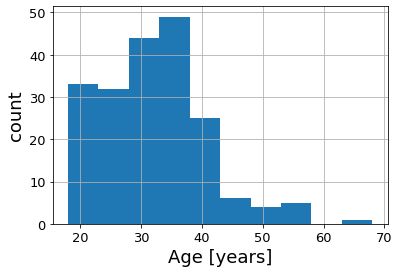

In [7]:
# let's plot the age distribution to get an idea who we are dealing with here

train_cases.Age.hist()
plt.ylabel('count')
plt.xlabel('Age [years]')

## Let's read in the pre-computed featurs

We first start with the power spectra. As we read, we make sure features are stored in
the same order as our meta info.

In [8]:
features = mne.externals.h5io.read_hdf5('./outputs/features_eyes-closed.h5')
psds = [features[sub]['psds'] for sub in train_cases.index]
X_psd = np.array(psds)
print(X_psd.shape)  # hooray we have an array! :D

(199, 53, 251)


In [9]:
# But what are these dimensions?

In [10]:
# For better plotting options we may later need the channel layout
# As we picked common channels, we need to know what are the remaining channels.

ch_names = pd.read_csv('./outputs/common_channels_validated.csv').name.tolist()
print(ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'F1', 'F2', 'P1', 'P2', 'AF3', 'AF4', 'P5', 'P6', 'FC5', 'FC6', 'C5', 'C6', 'TP7', 'TP8', 'PO5', 'PO6', 'PO3', 'PO4', 'CP1', 'CP2', 'CP3', 'CP4', 'C1', 'C2', 'F5', 'F6', 'FC3', 'FC4', 'FC1', 'FC2', 'CP5', 'CP6', 'PO7', 'PO8']


In [11]:
# We can get the frequency information from the features file

freqs = features[train_cases.index[0]]['meta_info']['freqs']

## Let's explore link between EEG power and age

In [12]:
# We do something crude first: averaging over all channels and taking the log

X_psd_ave = np.log10(X_psd.mean(1))
X_psd_ave.shape

(199, 251)

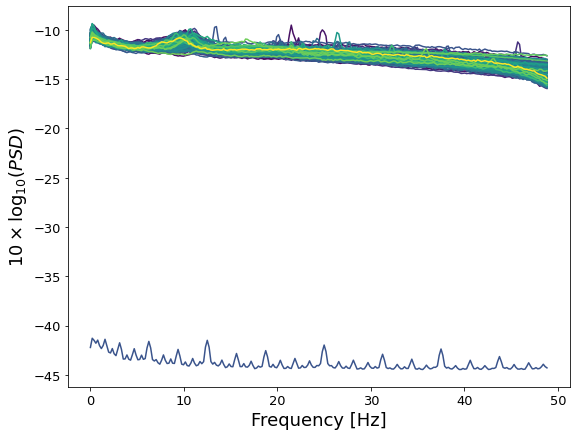

In [13]:
# Let's visually explore the link between power and age by somple plotting with color codes
from sklearn.preprocessing import MinMaxScaler

y = train_cases.Age.values

age_sorter = np.argsort(y)
sorted_age = y[age_sorter]

ms = MinMaxScaler()
color_code = ms.fit_transform(sorted_age[:, None])[:, 0]
color = plt.matplotlib.cm.viridis(color_code)

plt.figure(figsize=(9, 7))
for ii, psd in enumerate(X_psd_ave[age_sorter]):
    plt.plot(freqs, psd, color=color[ii]);
# plt.ylim(-16, -8)
plt.ylabel(r'$10 \times \log_{10}(PSD)$')
plt.xlabel("Frequency [Hz]")
plt.show()

### Oh no!! We have a really bad outlier here! Lets' get rid of this one and do it again

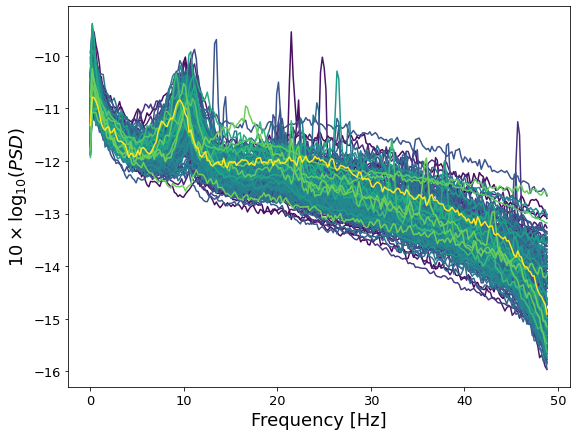

In [14]:
bad_idx = X_psd_ave.mean(1).argmin()
good_idx = list(range(len(X_psd_ave)))
good_idx.pop(bad_idx)

y = train_cases.Age.values[good_idx]
age_sorter = np.argsort(y)
sorted_age = y[age_sorter]

X_psd_ave = X_psd_ave[good_idx]

ms = MinMaxScaler()
color_code = ms.fit_transform(sorted_age[:, None])[:, 0]
color = plt.matplotlib.cm.viridis(color_code)

plt.figure(figsize=(9, 7))
for ii, psd in enumerate(X_psd_ave[age_sorter]):
    plt.plot(freqs, psd, color=color[ii]);
# plt.ylim(-16, -8)
plt.ylabel(r'$10 \times \log_{10}(PSD)$')
plt.xlabel("Frequency [Hz]")
plt.show()

This does not reveal a clear pattern yet. Let's see if binning by age group gives a clearer picture. For this we shall add a gorup variable to our data frame. After looking at the histogram above, my gut feeling is telling me that we can do around 4 groups.

In [15]:
bad_idx

22

Now we als have to remember to remove that bad index from the data

In [16]:
train_cases = train_cases.iloc[good_idx]

In [17]:
train_cases['age_group'] = pd.cut(train_cases.Age, 4)

In [18]:
# now we can do a group by after setting the index to range
train_cases = train_cases.reset_index()

In [19]:
# note that we have now a 0-based RangeIndex that we can use to access the features
train_cases

,Code,Gender,Age,Weight lb,Education Level,age_group
0,sub-CBM00268,M,28,NaN,Secondary School,"(17.95, 30.5]"
1,sub-CBM00004,M,23,NaN,High School,"(17.95, 30.5]"
2,sub-CBM00153,F,35,NaN,High School,"(30.5, 43.0]"
3,sub-CBM00236,M,30,139.0,University School,"(17.95, 30.5]"
4,sub-CBM00238,M,26,143.0,High School,"(17.95, 30.5]"
...,...,...,...,...,...,...
193,sub-CBM00080,M,32,156.0,High School,"(30.5, 43.0]"
194,sub-CBM00214,M,29,215.0,High School,"(17.95, 30.5]"
195,sub-CBM00224,M,34,144.0,University School,"(30.5, 43.0]"
196,sub-CBM00035,M,20,130.0,Secondary School,"(17.95, 30.5]"


Text(0.5, 0, 'Frequency [Hz]')

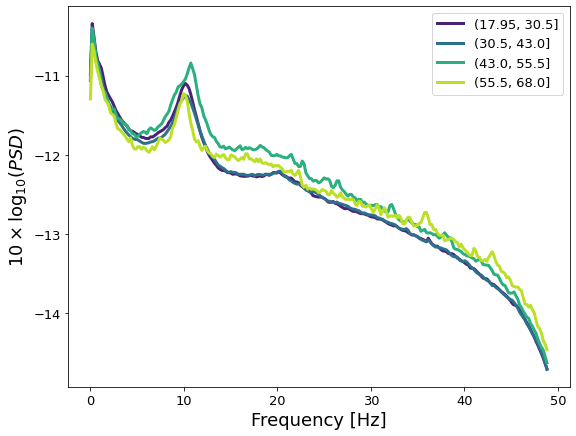

In [20]:
color = plt.cm.viridis(np.linspace(0.1, 0.9, 4))
plt.figure(figsize=(9, 7))
for ii, (key, inds) in enumerate(train_cases.groupby('age_group').groups.items()):
    plt.plot(freqs, X_psd_ave[inds].mean(0), color=color[ii], label=key, linewidth=3)
plt.legend()
plt.ylabel(r'$10 \times \log_{10}(PSD)$')
plt.xlabel("Frequency [Hz]")

Now we can see that that oldest people have much lower alpha power, which I would expect based on my prior knowledge.

## Spatial patterns

Yet another way to look at things is spatial. We now use the previously defined age groups to extract EEG topographies.
We will need MNE Python here to get this job done.

In [21]:
# we compose a header object to handel channel locations
info = mne.create_info(ch_names=ch_names, ch_types=['eeg'] * len(ch_names), sfreq=200.0)

In [22]:
# average EEG power for every channel across frequencies within age groups
age_groups = train_cases.groupby('age_group').groups

X_ave = np.array([X_psd[inds].mean(0).mean(1) for inds in age_groups.values()])

In [23]:
X_ave.shape  # frequency bands, channels

(4, 53)

In [24]:
# fake being an MNE Evoked object :D
average_psds = mne.EvokedArray(data=X_ave.T, info=info)

In [25]:
# now we need to add the channel information using a standard montage

montage = mne.channels.make_standard_montage('standard_1005')
average_psds.set_montage(montage)

<Evoked | '' (average, N=1), 0 – 0.015 sec, baseline off, 53 ch, ~78 kB>

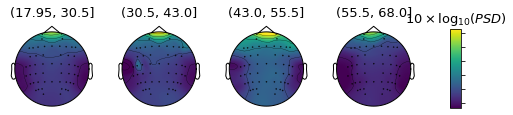

In [26]:
fig_psd = average_psds.plot_topomap(cmap='viridis', cbar_fmt='', vmin=np.min, vmax=np.max, show=False);
titles = [k for k in age_groups.keys()] + [r'$10 \times \log_{10}(PSD)$']
axes = fig_psd.findobj(plt.Axes)
for ii, ax in enumerate(axes):
    ax.set_title(titles[ii])
plt.show()

This is unfortunately inconclive. It is possible that occular artifacts are overshadowing what we're interested in. Let's do something crude and remove the frontal channels. But how?

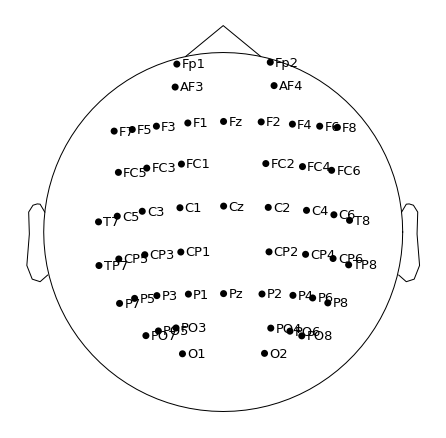

In [27]:
average_psds.plot_sensors(show_names=True);

In [28]:
average_psds.drop_channels(['Fp1', 'Fp2'])

<Evoked | '' (average, N=1), 0 – 0.015 sec, baseline off, 51 ch, ~76 kB>

Will it be better now?

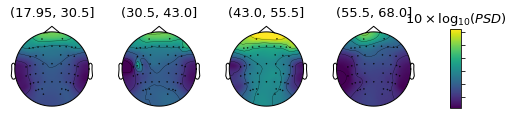

In [29]:
fig_psd = average_psds.plot_topomap(cmap='viridis', cbar_fmt='', vmin=np.min, vmax=np.max, show=False);
titles = [k for k in age_groups.keys()] + [r'$10 \times \log_{10}(PSD)$']
axes = fig_psd.findobj(plt.Axes)
for ii, ax in enumerate(axes):
    ax.set_title(titles[ii])
plt.show()

Well let's say a bit.

In [30]:
average_psds.drop_channels(['AF3', 'AF4'])

<Evoked | '' (average, N=1), 0 – 0.015 sec, baseline off, 49 ch, ~74 kB>

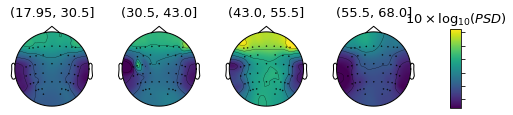

In [31]:
fig_psd = average_psds.plot_topomap(cmap='viridis', cbar_fmt='', vmin=np.min, vmax=np.max, show=False);
titles = [k for k in age_groups.keys()] + [r'$10 \times \log_{10}(PSD)$']
axes = fig_psd.findobj(plt.Axes)
for ii, ax in enumerate(axes):
    ax.set_title(titles[ii])
plt.show()

# Additional exercise for plotting:



1. Compute pearson correlations (or linear models) to capture and visulaize the link between age and power at each frequency.
Then plot it!

2. how do things look for the eyes opened condition?

# A first naive model

Shall we still try to see if a stats model can do better than us and find patterns that predict the age?


In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [33]:
freq_selection_idx = (freqs > 2) & (freqs < 20)

# let's select some channel regions and average

chan_selection = [ch for ch in ch_names if ch.startswith("P")]
chan_selection_idx = [info['ch_names'].index(ch) for ch in chan_selection]
X_parietal = X_psd[:, chan_selection_idx][:, :, freq_selection_idx]

chan_selection = [ch for ch in ch_names if ch.startswith("C")]
chan_selection_idx = [info['ch_names'].index(ch) for ch in chan_selection]
X_central = X_psd[:, chan_selection_idx][:, :, freq_selection_idx]

X_ = np.concatenate([X_central.mean(1), X_parietal.mean(1)], axis=1)[good_idx]

In [34]:
X_.shape

(198, 184)

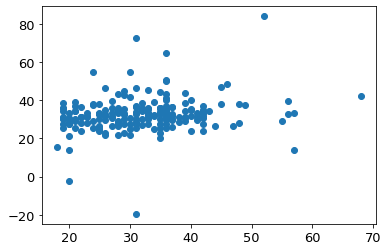

In [35]:
ridge = make_pipeline(StandardScaler(), Ridge(alpha=5))
y_pred = cross_val_predict(estimator=ridge, X=X_, y=y)
plt.scatter(y, y_pred)

### Ugh ... negative predictions ... maybe we can use a model that does not allow for that?

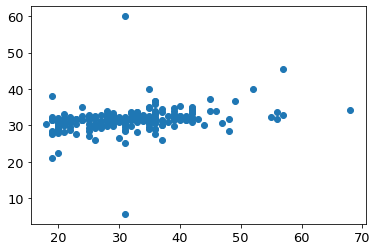

In [36]:
from sklearn.linear_model import GammaRegressor
gamma = make_pipeline(StandardScaler(), GammaRegressor(alpha=5))
y_pred_gamma = cross_val_predict(estimator=gamma, X=X_, y=y)
plt.scatter(y, y_pred_gamma)

In [37]:
from sklearn.metrics import r2_score
print(r2_score(y_true=y, y_pred=y_pred_gamma))

0.06991581537682967


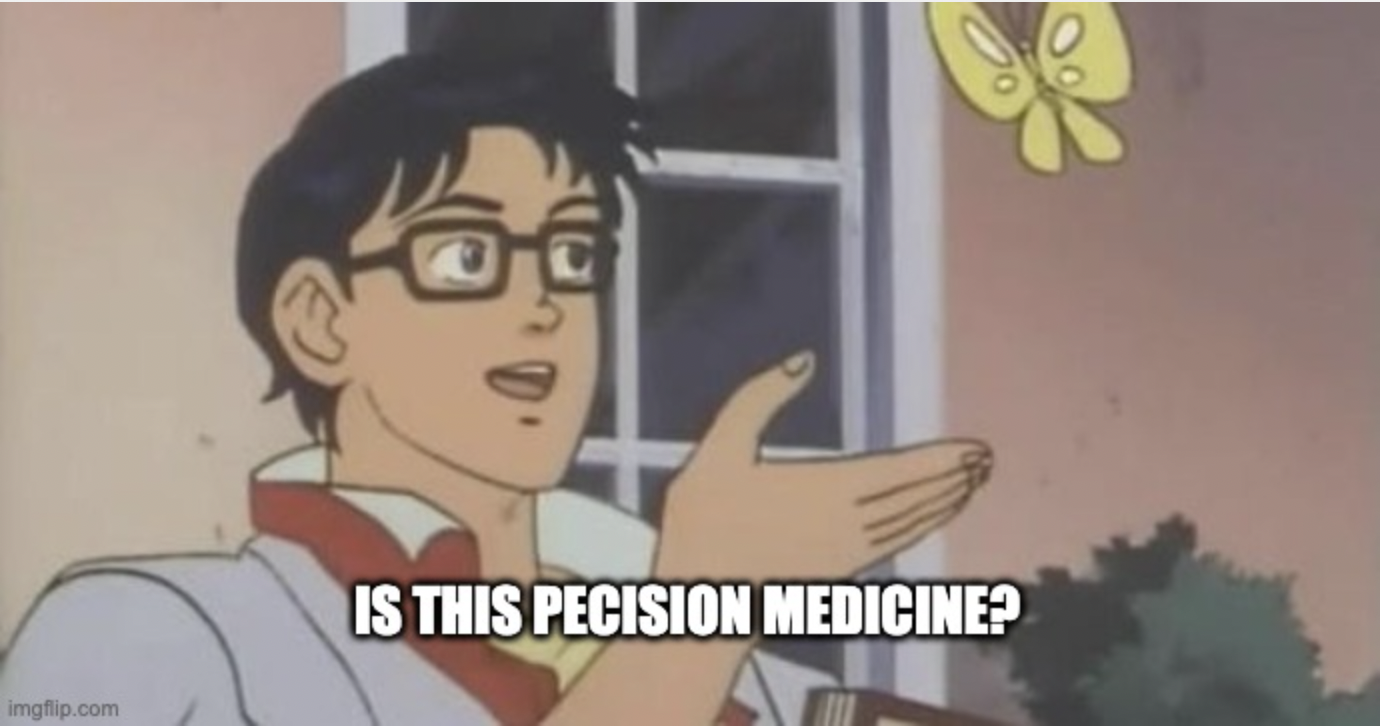

In [38]:
from IPython.display import Image
Image(filename='./outputs/demo.png')

# Additional exercise for modeling:


1. What happens if we do not remove the bad case?

2. Do these models generalize to the 50 left-out subjects?

3. Can performance be improved by removing the frontal channels? and would that be a good idea? 

4. Can you come up with better ad-hoc features based on what we have seen?

5. Can a loss that is robust to outliers help? What about changing the regularization parameter?